# Analyzing AI Content in Amazon Reviews

Almost 2,000 records of randomly selected Amazon.com Product Reviews from 2020 to date were processed through [Originality.AI](originality.ai) to determine the probability of AIContent. A series of experiments were performed on this data, to get more information about the relationship between AIContent and the different features of the reviews. This notebook describes 3 of the experiments done. The purpose of these experiments is to answer the following questions:

1. Is there a correlation between the severity of a review and the tested quantity of aiContent? Or in other words, are more extreme Reviews (5 - very good or 1 - very bad) more or less likely to have aiContent?
    
2. Is there any relationship between the helpfulness of a Review and its AIContent?

3. Has there been an increase in AIContent in Amazon reviews since the introduction of Chat GPT in the last Quarter of 2022? 

In [1]:
# import custom helper functions
# also imports the usual package libraries like pandas, numpy, etc
from helperfiles import *        

/Users/uche/miniconda3/envs/originality/lib/python3.8/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## The Data 

Almost 27K records of raw data were scraped from Amazon. The data was cleaned using the standard processes, and customer sensitive information was removed. Approximately 2K were processed by the through [Originality.AI](originality.ai)'s state-of-the-art AI detector to provide viable records for analysis. Statistical tests were performed on the dataset to confirm that the data used for the analysis, was representative of the original raw data. This is detailed in the Appendix.

In [2]:
df = get_data_for_analysis()
display(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2060 entries, 0 to 2059
Data columns (total 10 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   date                  2060 non-null   datetime64[ns]
 1   isVerified            2060 non-null   bool          
 2   ratingScore           2060 non-null   int64         
 3   totalCategoryRatings  2060 non-null   int64         
 4   totalCategoryReviews  2060 non-null   int64         
 5   helpfulCount          2060 non-null   int64         
 6   aiContent             2060 non-null   float64       
 7   productGroup          2060 non-null   object        
 8   averageRating         2060 non-null   float64       
 9   goodreadsRating       241 non-null    float64       
dtypes: bool(1), datetime64[ns](1), float64(3), int64(4), object(1)
memory usage: 147.0+ KB


None

,date,isVerified,ratingScore,totalCategoryRatings,totalCategoryReviews,helpfulCount,aiContent,productGroup,averageRating,goodreadsRating
0,2023-08-17,False,1,18,14,3,0.0006,Children Books,4.8,4.6
1,2023-07-07,True,5,432,64,33,0.0001,Children Books,4.8,4.6
2,2023-07-12,True,5,432,64,15,0.0008,Children Books,4.8,4.6
3,2023-07-19,True,5,432,64,19,0.0002,Children Books,4.8,4.6
4,2022-10-07,True,5,432,64,26,0.0004,Children Books,4.8,4.6


## 1. Extreme reviews vs likelihood of aiContent

This experiment investigates how likely a review that is extremely rated (1 or 5) is more likely to have aiContent than a moderately rated (2, 3 or 4) review. 

Process: 

1. the reviews are categorized into a `ratingSeverity` binary feature: Extreme (1s and 5s) or Moderate (2s, 3s, 4s)
2. visual anslysis is performed by by plotting the barplot of this feature against the `aiContent`.
3. statistical analysis is performed by the ANOVA (Analysis of Variance), the common method of comparing categorical data (i.e. non-numeric data) with numerical values.

In [3]:
from scipy.stats import spearmanr, kendalltau, pearsonr
import math

In [4]:
# convert ratingScore into ratingSeverity category 'extreme', and 'moderate'
def severe(ratingScore):
    ratingSeverity = 'Extreme (5 or 1)' if (ratingScore==5 or ratingScore==1) else \
                     'Moderate (2, 3, or 4)' 
    return ratingSeverity
df['ratingSeverity'] = df['ratingScore'].apply(lambda x: severe(x))
df.head(3)

,date,isVerified,ratingScore,totalCategoryRatings,totalCategoryReviews,helpfulCount,aiContent,productGroup,averageRating,goodreadsRating,ratingSeverity
0,2023-08-17,False,1,18,14,3,0.0006,Children Books,4.8,4.6,Extreme (5 or 1)
1,2023-07-07,True,5,432,64,33,0.0001,Children Books,4.8,4.6,Extreme (5 or 1)
2,2023-07-12,True,5,432,64,15,0.0008,Children Books,4.8,4.6,Extreme (5 or 1)


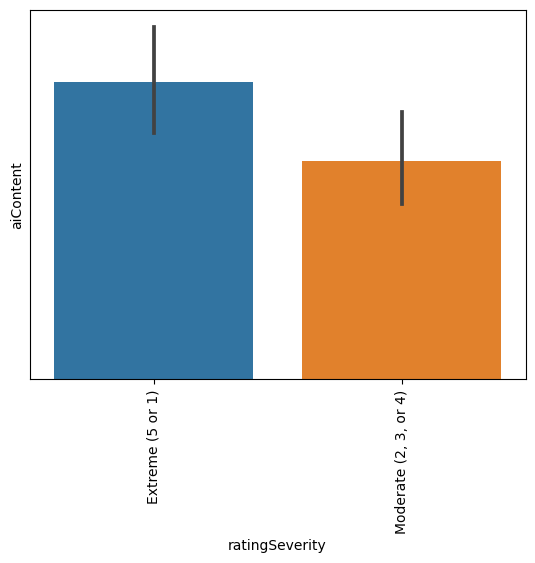

p value is 0.031420.
AI_Content and ratingSeverity are correlated.


In [5]:
# call the categorical testing function that plots the graph and performs the ANOVA test
categorical_testing(df, 'ratingSeverity')

### Other categorical testing:

Other categorical features were tested/analyzed with interesting results:

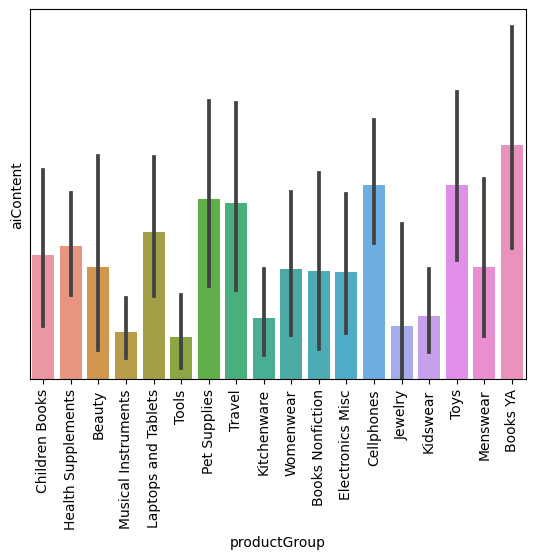

p value is 0.020994.
AI_Content and productGroup are correlated.


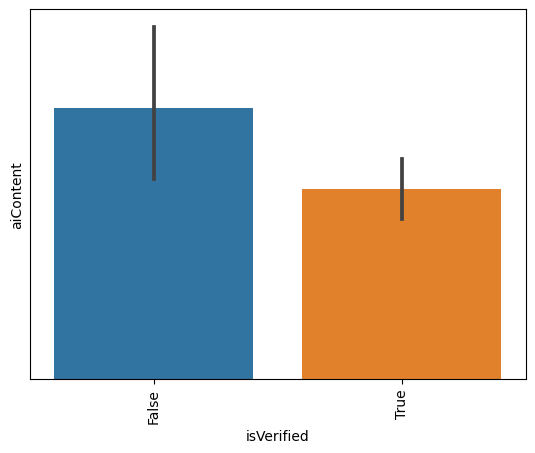

p value is 0.024949.
AI_Content and isVerified are correlated.


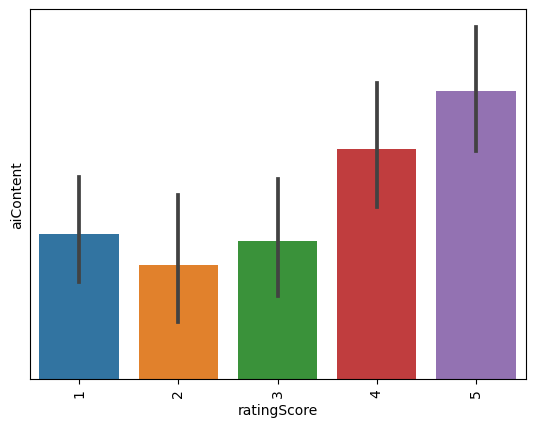

p value is 0.000358.
AI_Content and ratingScore are correlated.


In [6]:
categorical_cols = ['productGroup', 'isVerified', 'ratingScore']

for col in categorical_cols:
    categorical_testing(df, col)
    

### Summary of Findings:
* Extreme reviews (rated 1 and 5) are more likely to be detected with AI Content than with moderate reviews.

* Verified reviews are less likely to be detected with AI Content.

* productGroup variation is not conclusive because of the overlapping between categories (e.g. a jewelry box item can be tagged under both Jewelry and Travel)




## 2. Helpfulness votes and AI Content

`helpfulScore` represents the votes that are given to a review by logged-in Amazon subscribers. This experiment wants to observe if there is any correlation between a review being widely regarded as helpful and its aiContent. 

Process:

1. Standardizing the helpfulScore: Due to the wide variety of the sample data, the range of values of the `helpfulCount` of each record is extreme. To properly analyze this relationship, the `helpfulCount` has to be standardized against the total Ratings and total Reviews of the product item that is being reviewed.

2. Visualizing the relationship between helpfulScore and aiContent with a scatter plot.

3. Statistics testing with the 3 common correlation tests (Spearman's Rho, Kendall Tau, and Pearson R) to check for a correlation between these features.


Results of the Spearman test: Correlation is -0.09721369907134281, with a p-value of 0.00001.
AI_Content and helpfulScore are correlated.

Results of the Kendall Tau test: Correlation is -0.06742367408043363, with a p-value of 0.00001.
AI_Content and helpfulScore are correlated.

Results of the Pearson test: Correlation is -0.05973953124337424, with a p-value of 0.00668.
AI_Content and helpfulScore are correlated.


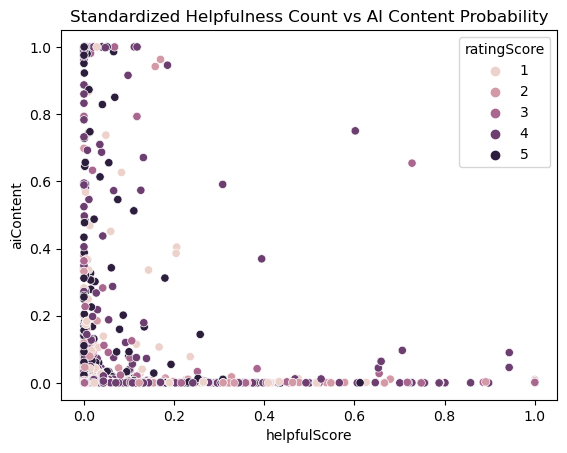

In [7]:
# standardizing the Score
df['helpfulScore'] = list(map(generate_helpfulScore,
        df.helpfulCount,
        df.totalCategoryRatings,
        df.totalCategoryReviews))

df.describe()

# call the numerical testing function that plots the scatter plot and returns the stats results
numerical_testing(df, 'helpfulScore')

### Analysis and Summary of Findings:

The three statistical tests and the visualization show that there is a statistically significant but quantitatively small negative correlation between the helpfulness of a review and its AI Content.



## 3: What is the trend of aiContent volume since Chat GPT launch?

This experiment observes the trend of aiContent volume prior to and after the launch of Chat GPT Launch.

Process:
1. The timeseries plot of annual daily `aiContent` from August 2020 (3 years before now (publishing date) and more than 2 years before Chat GPT launch) to the present date was visualized. 
2. Using Facebook Prophet's timeseries analysis and Forecasting tool, the trend of change in aiContent across the years can be studied

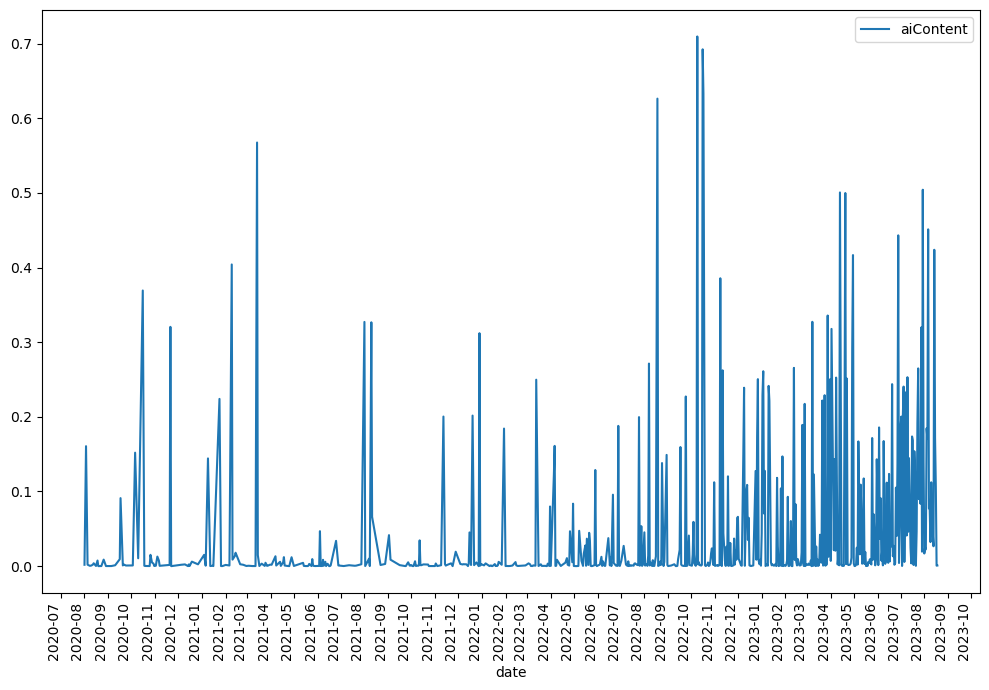

In [8]:
time_df = generate_df_plot(df, start='2020-08') # returns this as a timeseries

### Observation:

There is a visible increase in the density of aiContent from the last quarter of 2022. 

11:39:18 - cmdstanpy - INFO - Chain [1] start processing
11:39:19 - cmdstanpy - INFO - Chain [1] done processing


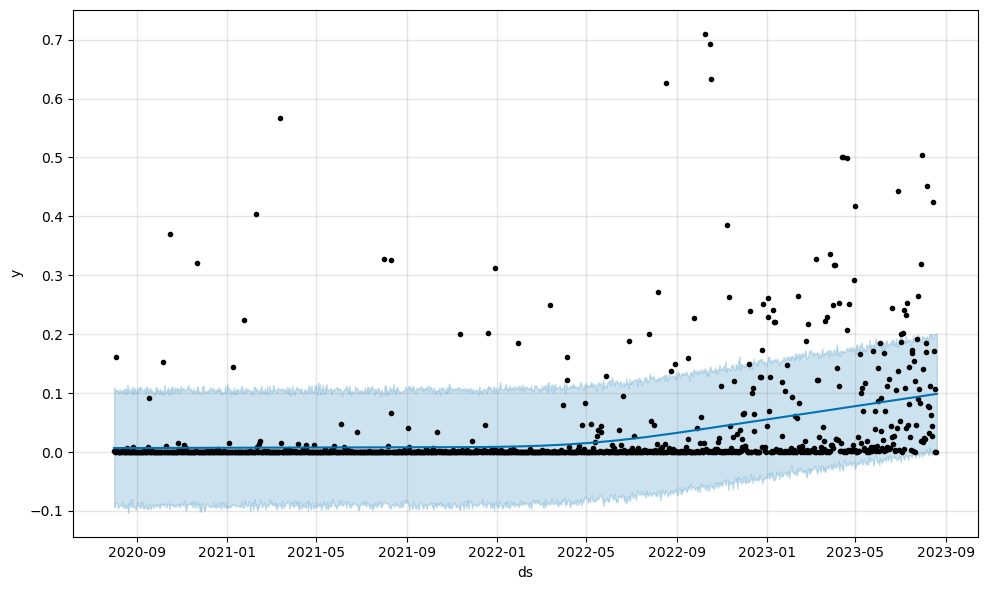

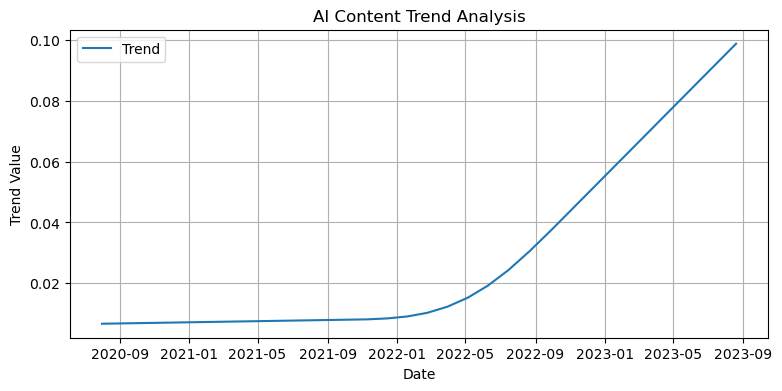

In [9]:
from prophet import Prophet
# create prediction model
m = analyze_timeseries_with_prophet(time_df)

In [10]:
# Calculate trend rise from Nov 30, 2022 to date
dates = pd.DataFrame({
    'ds': pd.to_datetime(
        ['2022-11-30', '2023-08-21']
        )})
forecast = m.predict(dates)['yhat']
trend_nov_2022, trend_aug_2022 = forecast
print("Rise from Nov 2022 to August 2023 is",
    f"{(trend_aug_2022-trend_nov_2022)*100/trend_nov_2022:.2f}%.")

Rise from Nov 2022 to August 2023 is 101.18%.


### Summary of Findings

* After a steady rate of neglible AIContent, the **trend** began increasing from early 2022 and has been on the rise since then. 

* From GPT launch to date, observable aiContent has increased from below 0.06 to 0.10, almost doubling its value.

# Appendix: Checking sample to population distribution

In order to generalize the results we get from analyzing the subset `df` of ~2K records to the set of 27K records collected, we need to confirm if it represents the same distribution.

Note that: this only generalizes to the larger dataset, not to the entire corpus of Amazon reviews as that dataset is not available to the public.

Process:

1. Visual analysis by plotting the bargraphs of the distributions.
2. Statistical analysis by using the KS and Chisquare power divergence tests.

Population size is 26533.
Sample size is 2060.
The sample is 7.8% of the population.


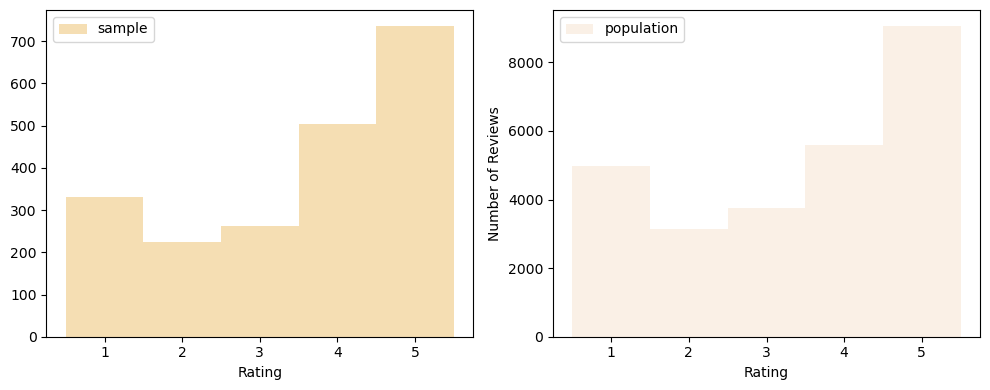

In [30]:
df_population = get_raw_data()
df_sample = get_data_for_analysis()
print(f"Population size is {len(df_population)}.")
print(f"Sample size is {len(df_sample)}.")
print(f"The sample is {len(df_sample)/len(df_population)*100:.1f}% of the population.")

# extract ratingScore from both distributions
sample = df_sample.ratingScore
population = df_population.ratingScore

dists = [sample, population]
titles = ['sample', 'population']
colors = ['wheat','linen']

# plot the bar graphs and extract the frequency distribution for statistics testing
counts_for_testing = plotbars(dists, titles, colors)


In [12]:
# statistics testing
from scipy.stats import ks_2samp, chisquare, entropy
# normalize the distributions
x = counts_for_testing[0]/counts_for_testing[0].sum()
y = counts_for_testing[1]/counts_for_testing[1].sum()

display(ks_2samp(x, y))
display(chisquare(x, y))
kld = entropy(x, y)
print("KullbackLeibler divergence",kld)

KstestResult(statistic=0.2, pvalue=1.0)

Power_divergenceResult(statistic=0.012080540324692043, pvalue=0.9999818308615351)

KullbackLeibler divergence 0.006028273297838671


### Summary of Findings

Visual Analysis: The two distributions are very similar. With very close examining, one will only notice that Rating '4' has a small delta across the 2 distributions. 

The null hypothesis or prevailing assumption of KS and Chisquare tests is that these two distributions are  the same, and therefore represent samples from the same source. For this to be challenged, the p-values of these tests should be less than 0.05, which is the usual value set for alpha - the level of statistical significance. 

As observed, they both have p-values > 0.05, showing that the Hypothesis that these the sample subset is representative of the population of raw data, can be assumed.

KLD measures how much one distribution differs from the other. The low KLD score (<0.01) indicates that the two distributions are very similar, which corresponds with the other statistics tests. 



In [36]:
import matplotlib.colors as colors
[x for x in colors.ColorConverter.colors.keys() if (len(x)==4 or len(x)==5 or len(x)==6)]

['aqua',
 'azure',
 'beige',
 'bisque',
 'black',
 'blue',
 'brown',
 'coral',
 'cyan',
 'gold',
 'gray',
 'green',
 'grey',
 'indigo',
 'ivory',
 'khaki',
 'lime',
 'linen',
 'maroon',
 'navy',
 'olive',
 'orange',
 'orchid',
 'peru',
 'pink',
 'plum',
 'purple',
 'salmon',
 'sienna',
 'silver',
 'snow',
 'teal',
 'tomato',
 'violet',
 'wheat',
 'white',
 'yellow']